In [1]:
# imports
import os
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager

from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from scipy.special import inv_boxcox
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# data prep
path = 'Data/Forecasting/QuarterlyStateBeerReports/'
list_dfs=[]
months = {'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'}
for file in os.listdir(path):
    if '~$' not in file:
        # get file
        filename = path + file
        df = pd.read_excel(filename)
        
        # only take Washington record
        df = pd.DataFrame(df[df.iloc[:, 0] == 'Washington'].iloc[:,1])
        
        # get date time
        year = file[:4]
        month = months[file[5:7]]
        df['month'] = year + '-' + month
        
        list_dfs.append(df)

# concat data
prod = pd.concat(list_dfs)

# clean up data
prod.rename(columns={'Unnamed: 1': 'production'}, inplace=True)
prod.sort_values(by='month', inplace=True)
prod.reset_index(drop=True, inplace=True)
prod = prod[['month', 'production']]

# change column types
prod['production'].replace(',','', regex=True, inplace=True)
prod['production'] = pd.to_numeric(prod['production'])
prod['month'] = pd.to_datetime(prod['month'])

# save data
prod.to_excel('Data/Forecasting/quarterly_beer_reports.xlsx')

# view data
prod.head()

,month,production
0,2015-01-01,138240.44
1,2015-04-01,151231.15
2,2015-07-01,161505.20
3,2015-10-01,135659.54
4,2019-01-01,141770.84


In [3]:
# TEMP FILL IN DATA
d = {
    '2016-01-01':140639.75,
    '2017-01-01':140639.75,
    '2018-01-01':140639.75,
    '2016-04-01':163443.93,
    '2017-04-01':163443.93,
    '2018-04-01':163443.93,
    '2016-07-01':174996.77,
    '2017-07-01':174996.77,
    '2018-07-01':174996.77,
    '2016-10-01':138930.07,
    '2017-10-01':138930.07,
    '2018-10-01':138930.07
}
df = pd.DataFrame(d.items(), columns=['month', 'production'])

prod = pd.concat([prod, df])

prod['month'] = pd.to_datetime(prod['month'])
prod.sort_values(by='month', inplace=True)
prod.reset_index(drop=True, inplace=True)

prod.head()

,month,production
0,2015-01-01,138240.44
1,2015-04-01,151231.15
2,2015-07-01,161505.20
3,2015-10-01,135659.54
4,2016-01-01,140639.75


In [4]:
# visualization settings

# use lato font
font_path = 'Reference/Lato/Lato-Regular.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

# set colors
col_yellow = '#ffa400'
col_green = '#256143'
col_brown = '#9c5421'
col_off_black = '#434343'
mpl.rcParams['text.color'] = col_off_black # title and legend
mpl.rcParams['xtick.color'] = col_off_black # tick marks
mpl.rcParams['ytick.color'] = col_off_black # tick marks
mpl.rcParams['axes.labelcolor'] = col_off_black # axes labels

# set font sizes
mpl.rcParams['axes.titlesize'] = 14 # title
mpl.rcParams['axes.labelsize'] = 12 # axes labels
mpl.rcParams['xtick.labelsize'] = 11 # tick marks
mpl.rcParams['ytick.labelsize'] = 11 # tick marks
mpl.rcParams['legend.title_fontsize'] = 12 # legend title
mpl.rcParams['legend.fontsize'] = 11 # legend text

# set figure size
figsz = (10,6)

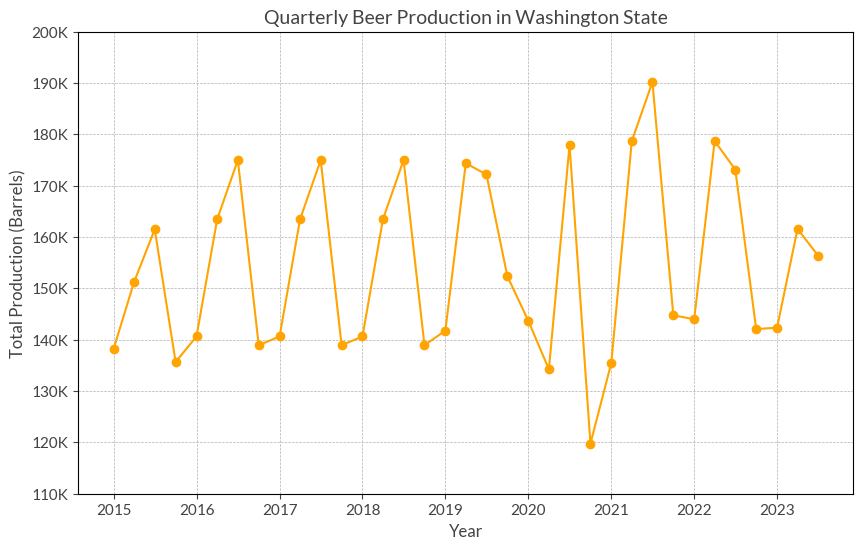

In [5]:
# plot time series
def plot_time_series(df: pd.DataFrame, y: str, y_label: str, adjust_y_labels: bool):
    # general function to plot timeseries data
    
    plt.figure(figsize=figsz)

    plt.plot(df['month'], df[y], color=col_yellow, marker='o')

    plt.title('Quarterly Beer Production in Washington State')
    plt.xlabel('Year')
    plt.ylabel(y_label)

    if adjust_y_labels == True:
        ylocs, ylabels = plt.yticks() 
        ylabels_new = ['{:,.0f}'.format(x) + 'K' for x in ylocs/1000]
        plt.yticks(ylocs, ylabels_new)

    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.grid(axis='x', linestyle='--', linewidth=0.5)

plot_time_series(df=prod, y='production', y_label='Total Production (Barrels)',
                adjust_y_labels=True)

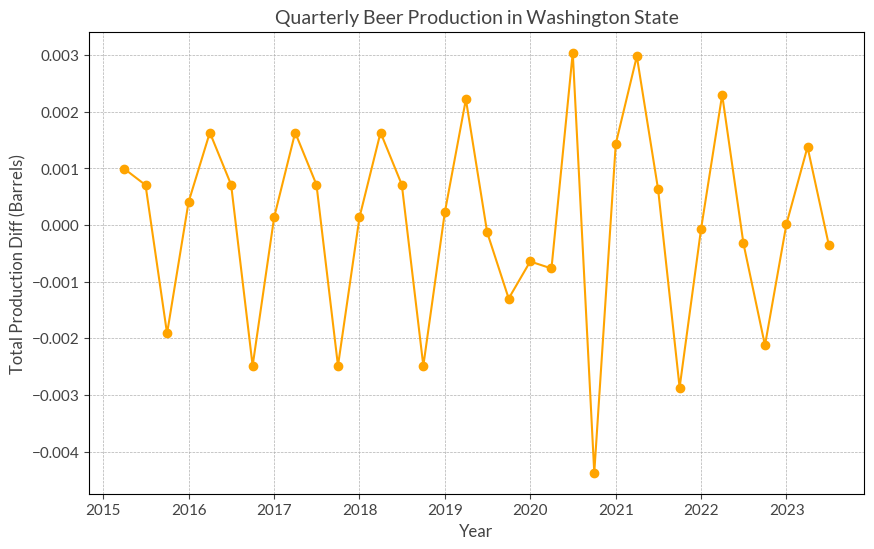

In [6]:
# make stationary (required by SARIMA)
prod['production_boxcox'], lam = boxcox(prod['production'])
prod['production_diff'] = prod['production_boxcox'].diff()
prod.dropna(inplace=True)

# plot stationary data
plot_time_series(df=prod, y='production_diff', y_label='Total Production Diff (Barrels)',
                adjust_y_labels=False)

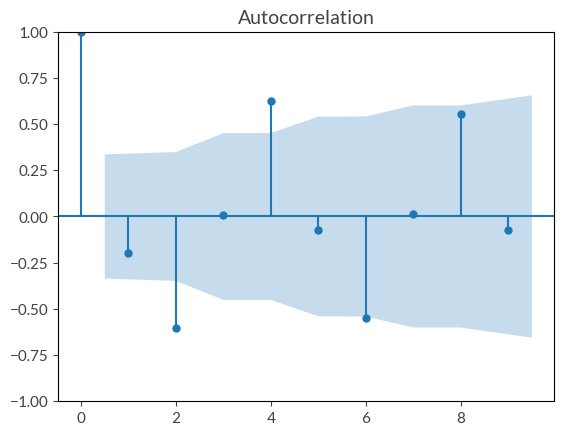

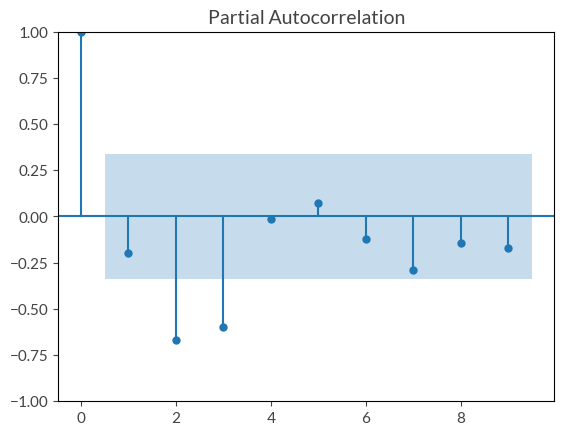

In [7]:
# plot ACF and PACF
plot_acf(prod['production_diff'], lags=9)
plot_pacf(prod['production_diff'], method='ywm', lags=9)
plt.show()

Annual seasonality (m=4) confirmed in above plots. The lags are also significant around the second lag for both plots. Overall this indicates that a SARIMA(2,1,2)(1,1,1)4 should be suitable.

In [8]:
# train and test set 
prod.index = pd.DatetimeIndex(prod.index).to_period('M')
train = prod.iloc[:-int(len(prod) * 0.2)]
test = prod.iloc[-int(len(prod) * 0.2):]

In [9]:
# build model
model = ARIMA(train['production_boxcox'], 
              order=(1,1,1),
              seasonal_order=(1,1,1,4)).fit()

# forecasts
boxcox_forecasts = model.forecast(len(test))
forecasts = inv_boxcox(boxcox_forecasts, lam)

/Users/mckenziemaidl/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


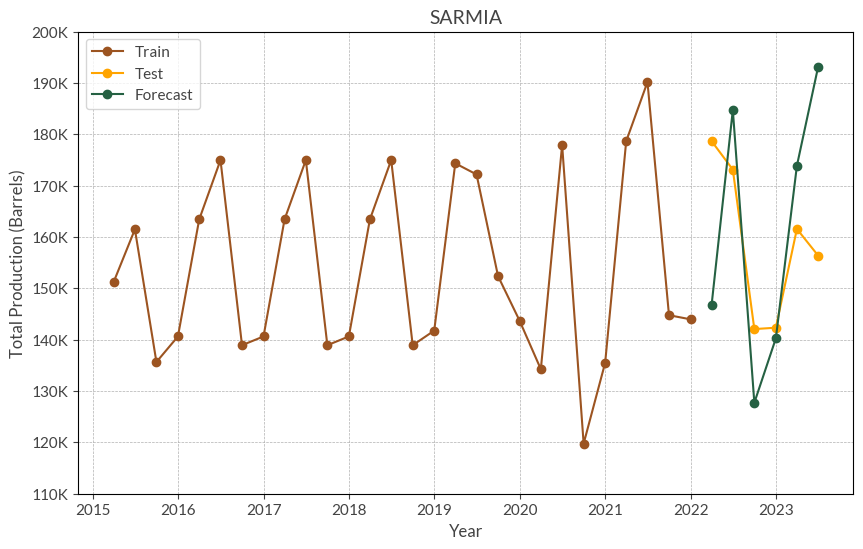

In [23]:
# plot forecasts
plt.figure(figsize=figsz)

plt.plot(train['month'], train['production'], color=col_brown, marker='o', label='Train')
plt.plot(test['month'], test['production'], color=col_yellow, marker='o', label='Test')
plt.plot(test['month'], forecasts, color=col_green, marker='o', label='Forecast')

plt.title('SARMIA')
plt.xlabel('Year')
plt.ylabel('Total Production (Barrels)')
plt.legend()

ylocs, ylabels = plt.yticks() 
ylabels_new = ['{:,.0f}'.format(x) + 'K' for x in ylocs/1000]
plt.yticks(ylocs, ylabels_new)

plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.grid(axis='x', linestyle='--', linewidth=0.5)